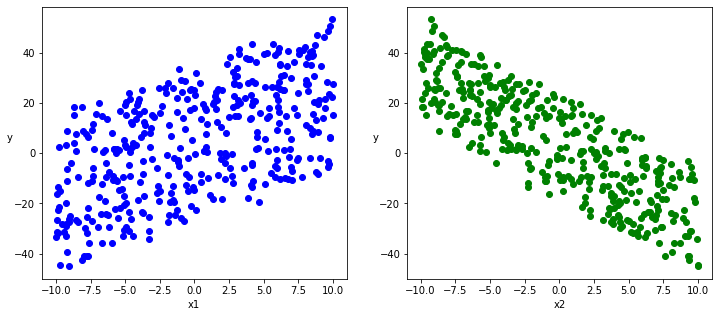

epoch = 50 loss =  1.13609576
w = [[1.98705184]
 [-3.00037074]]
b = [[2.54698038]]
epoch = 100 loss =  2.6106925
w = [[1.99336135]
 [-3.00197148]]
b = [[2.88364291]]
epoch = 150 loss =  0.965905
w = [[1.98102689]
 [-3.00410461]]
b = [[2.9309032]]
epoch = 200 loss =  2.56938362
w = [[1.97712445]
 [-3.00340986]]
b = [[2.93677592]]


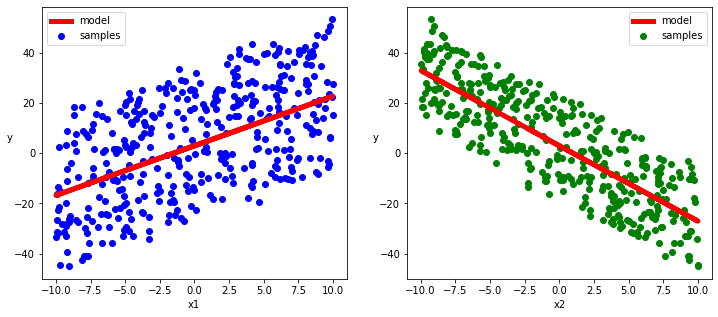

In [4]:
# 低阶API例子
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# 构建样本数据
n = 400
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)

# 可视化数据
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)
ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)

w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype = tf.float32))

# 构建模型
class LinearRegression:     
    def __call__(self,x): 
        return x@w + b

    def loss_func(self,y_true,y_pred):  
        return tf.reduce_mean((y_true - y_pred)**2/2)

model = LinearRegression()

# 训练
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    return loss

def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)
        if epoch%50==0:
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200)

# 评估模型
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)
ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()


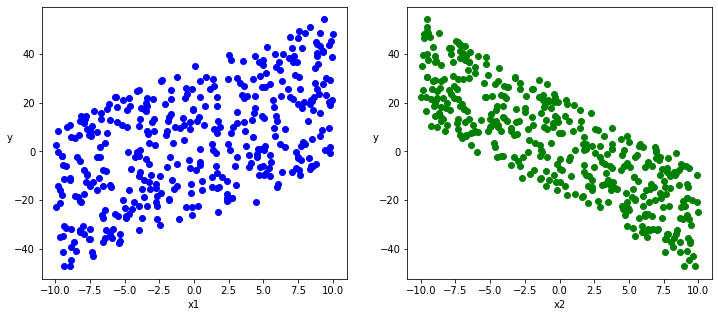

epoch = 50 loss =  3.06452918
w = [[2.03222299]
 [-2.98456621]]
b = [2.97466087]
epoch = 100 loss =  6.05549288
w = [[2.03553915]
 [-2.99598837]]
b = [3.03103518]
epoch = 150 loss =  2.71386552
w = [[2.02506804]
 [-2.99480081]]
b = [3.03300261]
epoch = 200 loss =  2.21094394
w = [[2.02013135]
 [-2.99201488]]
b = [3.03118944]


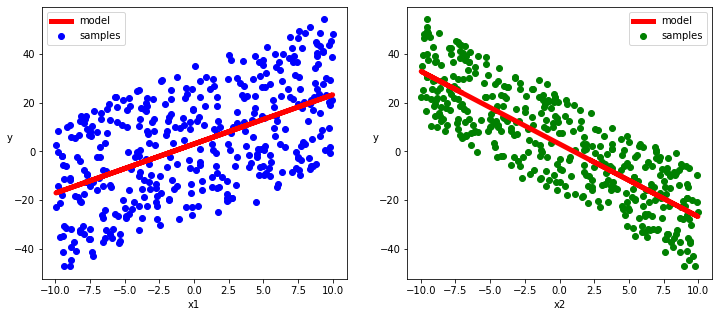

In [7]:
# 中阶API例子
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, losses, metrics, optimizers
from matplotlib import pyplot as plt 

# 构建样本数据
n = 400
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)

# 可视化数据
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)
ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 100).batch(10) \
     .prefetch(tf.data.experimental.AUTOTUNE)

# 构建模型
model = layers.Dense(units = 1) 
model.build(input_shape = (2,))
model.loss_func = losses.mean_squared_error
model.optimizer = optimizers.SGD(learning_rate=0.001)

# 训练
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.variables)
    model.optimizer.apply_gradients(zip(grads,model.variables))
    return loss

features, labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss = tf.constant(0.0)
        for features, labels in ds:
            loss = train_step(model,features,labels)
        if epoch%50==0:
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",model.variables[0])
            tf.print("b =",model.variables[1])

train_model(model,epochs = 200)

# 评估模型
w,b = model.variables
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)
ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()


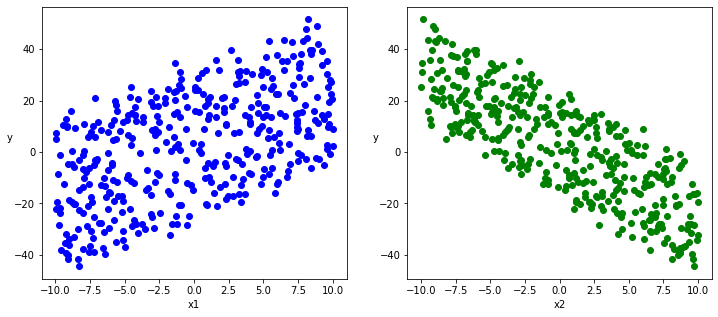

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
40/40 [==============================] - 0s 848us/step - loss: 612.2385 - mae: 20.4478
Epoch 2/200
40/40 [==============================] - 0s 798us/step - loss: 597.4737 - mae: 20.2057
Epoch 3/200
40/40 [==============================] - 0s 823us/step - loss: 582.9951 - mae: 19.9575
Epoch 4/200
40/40 [==============================] - 0s 823us/step - loss: 568.8062 - mae: 19.7152
Epoch 5/200
40/40 [==============================] - 0s 773us/step - loss: 554.8420 - mae: 19.4764
Epoch 6/200
40/40 [==============================] - 0s 773us/step - loss: 541.3161 - mae: 19.2375
Epoch 7/200
40/40 [==============================] - 0s 773us/

40/40 [==============================] - 0s 823us/step - loss: 3.9807 - mae: 1.6084
Epoch 162/200
40/40 [==============================] - 0s 798us/step - loss: 3.9669 - mae: 1.6061
Epoch 163/200
40/40 [==============================] - 0s 823us/step - loss: 3.9558 - mae: 1.6039
Epoch 164/200
40/40 [==============================] - 0s 773us/step - loss: 3.9417 - mae: 1.6014
Epoch 165/200
40/40 [==============================] - 0s 773us/step - loss: 3.9315 - mae: 1.5996
Epoch 166/200
40/40 [==============================] - 0s 748us/step - loss: 3.9200 - mae: 1.5974
Epoch 167/200
40/40 [==============================] - 0s 798us/step - loss: 3.9115 - mae: 1.5956
Epoch 168/200
40/40 [==============================] - 0s 823us/step - loss: 3.9015 - mae: 1.5941
Epoch 169/200
40/40 [==============================] - 0s 748us/step - loss: 3.8912 - mae: 1.5921
Epoch 170/200
40/40 [==============================] - 0s 773us/step - loss: 3.8815 - mae: 1.5896
Epoch 171/200
40/40 [=============

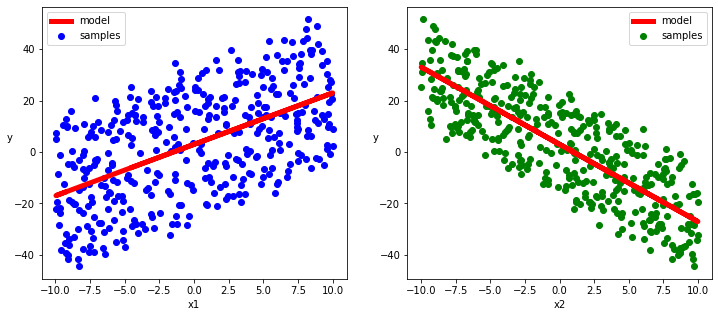

In [8]:
# 高阶API例子
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, losses, metrics, optimizers
from matplotlib import pyplot as plt 

# 构建样本数据
n = 400
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)

# 可视化数据
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)
ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

# 构建模型
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Dense(1,input_shape =(2,)))
model.summary()

# 训练
model.compile(optimizer="adam",loss="mse",metrics=["mae"])
model.fit(X,Y,batch_size = 10,epochs = 200)  
tf.print("w = ",model.layers[0].kernel)
tf.print("b = ",model.layers[0].bias)

# 评估模型
w,b = model.variables
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)
ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()
